In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import 
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


In [11]:
from natsort import natsorted
files = natsorted(os.listdir('./train/'))
path_from = "./train"
path_dest = "./val"

split_ratio = 0.2

data_range = int(len(files) / 2)
data_range_start = int(data_range * (1 - split_ratio))

for i in range(data_range_start, data_range):
    os.replace(f'{path_from}/cat.{i}.jpg', f'{path_dest}/cat.{i}.jpg')
    os.replace(f'{path_from}/dog.{i}.jpg', f'{path_dest}/dog.{i}.jpg')

In [42]:
input_size = 299
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")
data_dir = "./"
batch_size = 32
# Create training and validation datasets
# dataset = datasets.ImageFolder('./train/', transform=data_transforms['train'])
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
# Create training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

Initializing Datasets and Dataloaders...


In [54]:
from torchvision.models.inception import inception_v3

model_ft = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model_ft.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model_ft.train(False)
num_classes = 2

# model_ft.AuxLogits.fc = nn.Linear(768, num_classes)
# model_ft.fc = nn.Linear(2048, num_classes)
# model_ft.add_module("sigm", nn.Sigmoid())

In [55]:
model_ft = model.to(device)

In [56]:
params_to_update = model_ft.parameters()
print("Params to learn:")
feature_extract = True

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [49]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=True):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [57]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [58]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size
model_name = "inception"
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [82]:
criterion = nn.CrossEntropyLoss()
num_epochs = 2
# Train and evaluate

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/1
----------


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


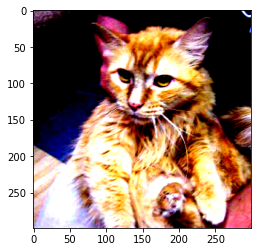

In [68]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.transpose(images[0].numpy(),[1,2,0]), )
plt.show()

In [85]:
images, labels = next(iter(dataloaders_dict['val']))
predict = model_ft(images)
pred_lab = torch.argmax(predict[0], dim=1)
torch.mean((pred_lab == labels).float())

tensor(0.5000)